[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03a-token-counter.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/03a-token-counter.ipynb)

#### [LangChain Handbook](https://pinecone.io/learn/langchain)

# Conversational Memory

## Extra Material: Token Counter

This is an additional piece of material alongside the [LangChain Handbook notebook on Conversational Memory](https://github.com/pinecone-io/examples/blob/master/generation/langchain/handbook/03-langchain-conversational-memory.ipynb).

In this notebook we will count the number of tokens used in a conversation for different conversational memory types.

We begin by installing the required libraries:

In [1]:
!pip install -qU langchain openai transformers seaborn


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import required libraries and objects:

In [2]:
from getpass import getpass

import openai
from langchain.callbacks import get_openai_callback
from tqdm.auto import tqdm
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory, BaseChatMessageHistory
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder
from langchain.schema.output_parser import StrOutputParser
from typing import List
from langchain_core.runnables import ConfigurableFieldSpec
from langchain_core.messages import BaseMessage, SystemMessage
from pydantic import BaseModel, Field
import os

To run the notebook we'll use OpenAI's `gpt-4.1-mini` model. We initialize it via LangChain like so:

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") \
    or getpass("Enter your OpenAI API key: ")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    temperature=0,
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-4.1-mini'
)

To count the number of tokens used during each call we will define a `count_tokens` function:

In [5]:
def count_tokens(chain, query, config=None):
    with get_openai_callback() as cb:
        # Handle both dict and string inputs
        if isinstance(query, str):
            query = {"query": query}
        
        # Use provided config or default
        if config is None:
            config = {"configurable": {"session_id": "default"}}
            
        result = chain.invoke(query, config=config)
        print(f'Spent a total of {cb.total_tokens} tokens')

    return {
        'result': result,
        'token_count': cb.total_tokens
    }

## Define System Prompt and LCEL Pipeline

In [6]:
# Define the prompt template
system_prompt = """The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know."""

prompt_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    MessagesPlaceholder(variable_name="history"),
    HumanMessagePromptTemplate.from_template("{query}"),
])

# Create the LCEL pipeline
output_parser = StrOutputParser()
pipeline = prompt_template | llm | output_parser




## Runnables with Message Histories

Here the Runnable Classes which utilize different types of memory are defined.

### Memory Type #1: Buffer Memory - Store the Entire Chat History

An alternative to `ConversationBufferMemory`. The simplest method, which stores the entire chat history as memory.

In [7]:
# Create a simple chat history storage
chat_map = {}

def get_chat_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in chat_map:
        # if session ID doesn't exist, create a new chat history
        chat_map[session_id] = InMemoryChatMessageHistory()
    return chat_map[session_id]

### Memory type #2: Summary - Store Summaries of Past Interactions

This is an LCEL-Comptaible alternative to `ConversationSummaryMemory`. We keep a summary of our previous conversation snippets as our history. The summarization is performed by an LLM.

In [8]:
class ConversationSummaryMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: List[BaseMessage] = Field(default_factory=list)
    llm: ChatOpenAI = Field(default_factory=ChatOpenAI)

    def __init__(self, llm: ChatOpenAI):
        super().__init__(llm=llm)

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add messages to the history and update the summary."""
        self.messages.extend(messages)
        
        # Construct the summary prompt
        summary_prompt = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(
                "Given the existing conversation summary and the new messages, "
                "generate a new summary of the conversation. Ensure to maintain "
                "as much relevant information as possible."
            ),
            HumanMessagePromptTemplate.from_template(
                "Existing conversation summary:\n{existing_summary}\n\n"
                "New messages:\n{messages}"
            )
        ])
        
        # Format the messages and invoke the LLM
        new_summary = self.llm.invoke(
            summary_prompt.format_messages(
                existing_summary=self.messages, 
                messages=messages
            )
        )
        
        # Replace the existing history with a single system summary message 
        self.messages = [SystemMessage(content=new_summary.content)]

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

# Create get_summary_chat_history function for summary memory
summary_chat_map = {}

def get_summary_chat_history(session_id: str, llm: ChatOpenAI) -> ConversationSummaryMessageHistory:
    if session_id not in summary_chat_map:
        summary_chat_map[session_id] = ConversationSummaryMessageHistory(llm=llm)
    return summary_chat_map[session_id]

### Memory type #3: Window Buffer Memory - Keep Latest Interactions

An LCEL-compatible alternative to `ConversationBufferWindowMemory`. Window memory where we keep only the last k interactions in our memory and intentionally drop the oldest ones

In [9]:
class BufferWindowMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: List[BaseMessage] = Field(default_factory=list)
    k: int = Field(default_factory=int)

    def __init__(self, k: int):
        super().__init__(k=k)
        # Add logging to help with debugging
        print(f"Initializing BufferWindowMessageHistory with k={k}")

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add messages to the history, removing any messages beyond
        the last `k` messages.
        """
        self.messages.extend(messages)
        # Add logging to help with debugging
        if len(self.messages) > self.k:
            print(f"Truncating history from {len(self.messages)} to {self.k} messages")
        self.messages = self.messages[-self.k:]

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

# Create get_chat_history function for window memory
window_chat_map = {}

def get_window_chat_history(session_id: str, k: int = 4) -> BufferWindowMessageHistory:
    print(f"get_window_chat_history called with session_id={session_id} and k={k}")
    if session_id not in window_chat_map:
        window_chat_map[session_id] = BufferWindowMessageHistory(k=k)
    return window_chat_map[session_id]

### Memory type #4:  Window + Summary Hybrid

An LCEL-compatible alternative to `ConversationSummaryBufferMemory`. Combines the benefits of both summary and buffer window memory. 

In [10]:
class ConversationSummaryBufferMessageHistory(BaseChatMessageHistory, BaseModel):
    messages: List[BaseMessage] = Field(default_factory=list)
    llm: ChatOpenAI = Field(default_factory=ChatOpenAI)
    k: int = Field(default_factory=int)

    def __init__(self, llm: ChatOpenAI, k: int):
        super().__init__(llm=llm, k=k)

    def add_messages(self, messages: List[BaseMessage]) -> None:
        """Add messages to the history, removing any messages beyond
        the last `k` messages and summarizing the messages that we drop.
        """
        existing_summary = None
        old_messages = None
        
        # See if we already have a summary message
        if len(self.messages) > 0 and isinstance(self.messages[0], SystemMessage):
            existing_summary = self.messages.pop(0)
            
        # Add the new messages to the history
        self.messages.extend(messages)
        
        # Check if we have too many messages
        if len(self.messages) > self.k:
            # Pull out the oldest messages...
            old_messages = self.messages[:-self.k]
            # ...and keep only the most recent messages
            self.messages = self.messages[-self.k:]
            
        if old_messages is None:
            # If we have no old_messages, we have nothing to update in summary
            return
            
        # Construct the summary chat messages
        summary_prompt = ChatPromptTemplate.from_messages([
            SystemMessagePromptTemplate.from_template(
                "Given the existing conversation summary and the new messages, "
                "generate a new summary of the conversation. Ensure to maintain "
                "as much relevant information as possible."
            ),
            HumanMessagePromptTemplate.from_template(
                "Existing conversation summary:\n{existing_summary}\n\n"
                "New messages:\n{old_messages}"
            )
        ])
        
        # Format the messages and invoke the LLM
        new_summary = self.llm.invoke(
            summary_prompt.format_messages(
                existing_summary=existing_summary or "No previous summary",
                old_messages=old_messages
            )
        )
        
        # Prepend the new summary to the history
        self.messages = [SystemMessage(content=new_summary.content)] + self.messages

    def clear(self) -> None:
        """Clear the history."""
        self.messages = []

# Create get_chat_history function for summary buffer memory
summary_buffer_chat_map = {}

def get_summary_buffer_chat_history(session_id: str, llm: ChatOpenAI, k: int = 4) -> ConversationSummaryBufferMessageHistory:
    if session_id not in summary_buffer_chat_map:
        summary_buffer_chat_map[session_id] = ConversationSummaryBufferMessageHistory(llm=llm, k=k)
    return summary_buffer_chat_map[session_id]

## Create Conversation Chains and Conversation Function

Create set of conversation chains that we'll be using:

In [11]:
# First, create separate history factory functions for each k value
def get_window_chat_history_k6(session_id: str, k: int = 6):
    return BufferWindowMessageHistory(k=k)  # Changed from WindowChatHistory

def get_window_chat_history_k12(session_id: str, k: int = 12):
    return BufferWindowMessageHistory(k=k)  # Changed from WindowChatHistory

def get_summary_buffer_chat_history_k6(session_id: str, llm: ChatOpenAI, k: int = 6):
    return ConversationSummaryBufferMessageHistory(llm=llm, k=k)  # Changed from SummaryBufferChatHistory

def get_summary_buffer_chat_history_k12(session_id: str, llm: ChatOpenAI, k: int = 12):
    return ConversationSummaryBufferMessageHistory(llm=llm, k=k)  # Changed from SummaryBufferChatHistory

# Then update the conversation_chains dictionary to use these specific functions
conversation_chains = {
    'RunnableWithMessageHistory': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_chat_history,
        input_messages_key="query",
        history_messages_key="history"
    ),
    'ConversationSummaryMessageHistory': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_chat_history,
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_history",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatOpenAI,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=llm,
            )
        ]
    ),
    'BufferWindowMessageHistory(k=6)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_window_chat_history_k6,  # Changed to k6 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="window_history_k6",
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=6,
            )
        ]
    ),
    'BufferWindowMessageHistory(k=12)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_window_chat_history_k12,  # Changed to k12 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="window_history_k12",
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=12,
            )
        ]
    ),
    'ConversationSummaryBufferMessageHistory(k=6)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_buffer_chat_history_k6,  # Changed to k6 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_buffer_k6",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatOpenAI,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=llm,
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=6,
            )
        ]
    ),
    'ConversationSummaryBufferMessageHistory(k=12)': RunnableWithMessageHistory(
        pipeline,
        get_session_history=get_summary_buffer_chat_history_k12,  # Changed to k12 specific function
        input_messages_key="query",
        history_messages_key="history",
        history_factory_config=[
            ConfigurableFieldSpec(
                id="session_id",
                annotation=str,
                name="Session ID",
                description="The session ID to use for the chat history",
                default="summary_buffer_k12",
            ),
            ConfigurableFieldSpec(
                id="llm",
                annotation=ChatOpenAI,
                name="LLM",
                description="The LLM to use for the conversation summary",
                default=llm,
            ),
            ConfigurableFieldSpec(
                id="k",
                annotation=int,
                name="k",
                description="The number of messages to keep in the history",
                default=12,
            )
        ]
    )
}

Let's define the conversation function:

In [12]:
queries = [
    "Good morning AI?",
    """My interest here is to explore the potential of integrating Large
    Language Models with external knowledge""",
    "I just want to analyze the different possibilities. What can you think of?",
    "What about the use of retrieval augmentation, can that be used as well?",
    """That's very interesting, can you tell me more about this? Like what
    systems would I use to store the information and retrieve relevant info?""",
    """Okay that's cool, I've been hearing about 'vector databases', are they
    relevant in this context?""",
    """Okay that's useful, but how do I go from my external knowledge to
    creating these 'vectors'? I have no idea how text can become a vector?""",
    """Well I don't think I'd be using word embeddings right? If I wanted to
    store my documents in this vector database, I suppose I would need to
    transform the documents into vectors? Maybe I can use the 'sentence
    embeddings' for this, what do you think?""",
    """Can sentence embeddings only represent sentences of text? That seems
    kind of small to capture any meaning from a document? Is there any approach
    that can encode at least a paragraph of text?""",
    """Huh, interesting. I do remember reading something about 'mpnet' or
    'minilm' sentence 'transformer' models that could encode small to
    medium sized paragraphs. Am I wrong about this?""",
    """Ah that's great to hear, do you happen to know how much text I can feed
    into these types of models?""",
    """I've never heard of hierarchical embeddings, could you explain those in
    more detail?""",
    """So is it like you have a transformer model or something else that creates
    sentence level embeddings, then you feed all of the sentence level
    embeddings into another separate neural network that knows how to merge
    multiple sentence embeddings into a single embedding?""",
    """Could you explain this process step by step from start to finish? Explain
    like I'm very new to this space, assume I don't have much prior knowledge
    of embeddings, neural nets, etc""",
    """Awesome thanks! Are there any popular 'heirarchical neural network'
    models that I can look up? Or maybe just the second stage that creates the
    hierarchical embeddings?""",
    "It seems like these HAN models are quite old, is there anything more recent?",
    "Can you explain the difference between transformer-XL and longformer?",
    "How much text can be encoded by each of these models?",
    """Okay very interesting, so before returning to earlier in the conversation.
    I understand now that there are a lot of different transformer (and not
    transformer) based models for creating the embeddings from vectors. Is that
    correct?""",
    """Perfect, so I understand text can be encoded into these embeddings. But
    what then? Once I have my embeddings what do I do?""",
    """I'd like to use these embeddings to help a chatbot or a question-answering
    system answer questions with help from this external knowledge base. I
    suppose this would come under information retrieval? Could you explain that
    process in a little more detail?""",
    """Okay great, that sounds like what I'm hoping to do. When you say the
    'chatbot or question-answering system generates an embedding', what do you
    mean exactly?""",
    """Ah okay, I understand, so it isn't the 'chatbot' model specifically
    creating the embedding right? That's how I understood your earlier comment.
    It seems more like there is a separate embedding model? And that encodes
    the query, then we retrieve the set of relevant documents from the
    external knowledge base? How is that information then used by the chatbot
    or question-answering system exactly?""",
    """Okay but how is the information provided to the chatbot or
    question-answering system?""",
    """So the retrieved information is given to the chatbot / QA system as plain
    text? But then how do we pass in the original query? How can the system
    distinguish between a user's query and all of this additional information?""",
    """That doesn't seem correct to me, my question is — if we are giving the
    chatbot / QA system the user's query AND retrieved information from an
    external knowledge base, and it's all fed into the model as plain text,
    how does the model know what part of the plain text is a query vs. retrieved
    information?""",
    """Yes I get that, but in the text passed to the model, how do we identify
    user prompt vs retrieved information?"""

]

def talk(conversation_chain):
    tokens_used = []
    # we loop through the conversation above, counting token usage as we go
    for user_query in tqdm(queries):
        try:
            # Get the history factory function name
            history_factory = conversation_chain.get_session_history.__name__
            
            # Create appropriate config based on history factory type
            if history_factory == "get_summary_chat_history":
                config = {"configurable": {"session_id": "summary_history", "llm": llm}}
            elif history_factory in ["get_window_chat_history_k6", "get_window_chat_history_k12"]:
                k = 6 if "k6" in history_factory else 12
                config = {"configurable": {"session_id": f"window_history_k{k}", "k": k}}
            elif history_factory in ["get_summary_buffer_chat_history_k6", "get_summary_buffer_chat_history_k12"]:
                k = 6 if "k6" in history_factory else 12
                config = {"configurable": {"session_id": f"summary_buffer_k{k}", "llm": llm, "k": k}}
            else:
                config = {"configurable": {"session_id": "basic_history"}}
                
            res = count_tokens(
                conversation_chain, 
                user_query,
                config=config
            )
            tokens_used.append(res['token_count'])
        except (openai.APIError, openai.APIConnectionError, openai.RateLimitError, openai.APIStatusError) as e:
            # we hit the token limit of the model or another API error, so break
            print(f"Hit error: {e}")
            break
    return tokens_used

## Run

In [13]:
counts = {}
# loop through each of our memory types above
for key, chain in conversation_chains.items():
    print(key)
    counts[key] = talk(chain)

RunnableWithMessageHistory


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 74 tokens
Spent a total of 561 tokens
Spent a total of 1542 tokens
Spent a total of 2334 tokens
Spent a total of 3540 tokens
Spent a total of 4418 tokens
Spent a total of 5297 tokens
Spent a total of 6052 tokens
Spent a total of 6905 tokens
Spent a total of 7658 tokens
Spent a total of 8283 tokens
Spent a total of 9117 tokens
Spent a total of 9775 tokens
Spent a total of 10682 tokens
Spent a total of 11617 tokens
Spent a total of 12609 tokens
Spent a total of 13592 tokens
Spent a total of 14244 tokens
Spent a total of 14928 tokens
Spent a total of 15850 tokens
Spent a total of 16871 tokens
Spent a total of 17540 tokens
Spent a total of 18310 tokens
Spent a total of 19002 tokens
Spent a total of 19719 tokens
Spent a total of 20373 tokens
Spent a total of 20892 tokens
ConversationSummaryMessageHistory


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 225 tokens
Spent a total of 1757 tokens
Spent a total of 3277 tokens
Spent a total of 3100 tokens
Spent a total of 3778 tokens
Spent a total of 3257 tokens
Spent a total of 3693 tokens
Spent a total of 2201 tokens
Spent a total of 1985 tokens
Spent a total of 2029 tokens
Spent a total of 1629 tokens
Spent a total of 3151 tokens
Spent a total of 3643 tokens
Spent a total of 4979 tokens
Spent a total of 4017 tokens
Spent a total of 4501 tokens
Spent a total of 4886 tokens
Spent a total of 2821 tokens
Spent a total of 2663 tokens
Spent a total of 3023 tokens
Spent a total of 3423 tokens
Spent a total of 2920 tokens
Spent a total of 3247 tokens
Spent a total of 2585 tokens
Spent a total of 2420 tokens
Spent a total of 2373 tokens
Spent a total of 2378 tokens
BufferWindowMessageHistory(k=6)


  0%|          | 0/27 [00:00<?, ?it/s]

Initializing BufferWindowMessageHistory with k=6
Spent a total of 74 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 449 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 209 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 424 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 594 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 508 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 842 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 326 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 631 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 451 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 310 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 660 tokens
Initializing BufferWindowMessageHistory with k=6
Spent a total of 515 tokens


  0%|          | 0/27 [00:00<?, ?it/s]

Initializing BufferWindowMessageHistory with k=12
Spent a total of 74 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 487 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 147 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 522 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 764 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 530 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 986 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 317 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 635 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 565 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 286 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total of 635 tokens
Initializing BufferWindowMessageHistory with k=12
Spent a total o

  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 74 tokens
Spent a total of 582 tokens
Spent a total of 182 tokens
Spent a total of 490 tokens
Spent a total of 656 tokens
Spent a total of 491 tokens
Spent a total of 945 tokens
Spent a total of 374 tokens
Spent a total of 618 tokens
Spent a total of 471 tokens
Spent a total of 316 tokens
Spent a total of 717 tokens
Spent a total of 595 tokens
Spent a total of 768 tokens
Spent a total of 786 tokens
Spent a total of 372 tokens
Spent a total of 822 tokens
Spent a total of 146 tokens
Spent a total of 587 tokens
Spent a total of 533 tokens
Spent a total of 596 tokens
Spent a total of 509 tokens
Spent a total of 578 tokens
Spent a total of 474 tokens
Spent a total of 541 tokens
Spent a total of 494 tokens
Spent a total of 570 tokens
ConversationSummaryBufferMessageHistory(k=12)


  0%|          | 0/27 [00:00<?, ?it/s]

Spent a total of 74 tokens
Spent a total of 489 tokens
Spent a total of 313 tokens
Spent a total of 523 tokens
Spent a total of 646 tokens
Spent a total of 510 tokens
Spent a total of 798 tokens
Spent a total of 306 tokens
Spent a total of 595 tokens
Spent a total of 430 tokens
Spent a total of 286 tokens
Spent a total of 686 tokens
Spent a total of 636 tokens
Spent a total of 819 tokens
Spent a total of 776 tokens
Spent a total of 373 tokens
Spent a total of 705 tokens
Spent a total of 139 tokens
Spent a total of 566 tokens
Spent a total of 563 tokens
Spent a total of 664 tokens
Spent a total of 506 tokens
Spent a total of 569 tokens
Spent a total of 464 tokens
Spent a total of 588 tokens
Spent a total of 527 tokens
Spent a total of 631 tokens


## Plot Token Usage for Various Memory Setups

Here we can see relative token usage of different memory types.

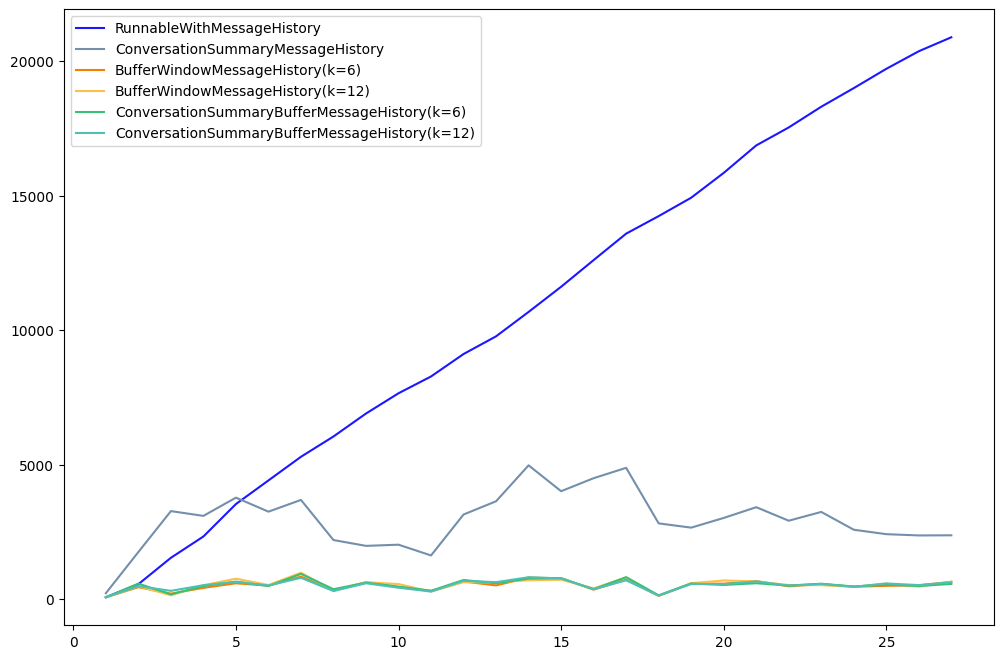

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.show()

Or, alternatively, a logarithmic plot to show the non `RunnableWithMessageHistory` (blue line) plots more clearly.

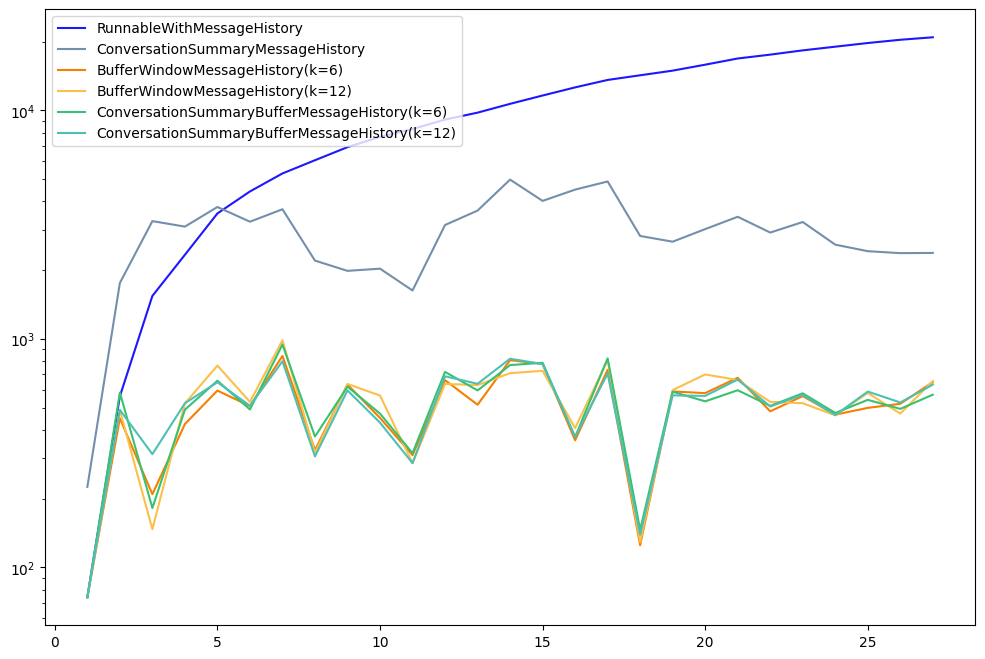

In [15]:

plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

---